# Sheet 6

## 1 Autoencoders: theory and practice

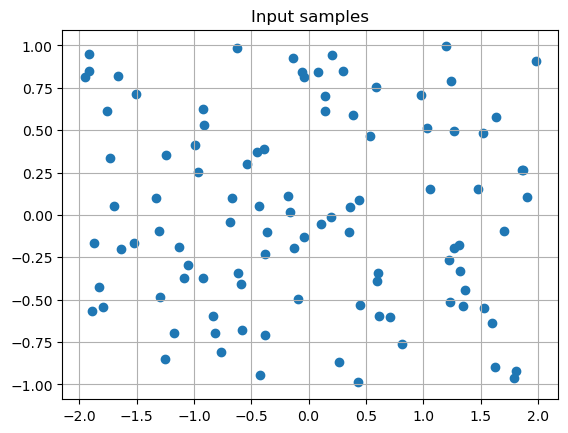

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


In [3]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import lightning as pl 

class Autoencoder(nn.Module):
    """
    Autoencoder with customizable architecture.
    :param hidden_channels: List containing the number of neurons in each hidden layer.
    :param latent_dim: Dimensionality of the bottleneck layer.
    :param input_dim: Dimensionality of the input.
    """
    
    def __init__(self, hidden_channels, latent_dim=1, input_dim=2):
        super().__init__()

        # Encoder
        layers = []
        in_dim = input_dim
        latent_index = len(hidden_channels) // 2
        for h_dim in hidden_channels[:latent_index]:
            layers.append(nn.Linear(in_dim, h_dim))
            if h_dim != latent_dim:  # No activation for the bottleneck
                layers.append(nn.ReLU())
            in_dim = h_dim
        self.encoder = nn.Sequential(*layers)
        
        # Define decoder (reverse of encoder)
        layers = []
        for h_dim in hidden_channels[latent_index:]:
            layers.append(nn.Linear(in_dim, h_dim))
            if h_dim != input_dim:  # No activation for the output layer
                layers.append(nn.ReLU())
            in_dim = h_dim
        self.decoder = nn.Sequential(*layers)
    

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        #print(x)
        return x
    

# Define PCA-based autoencoder
class PCAAutoencoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=1):
        """
        PCA-based Autoencoder that mimics the behavior of PCA up to a linear transformation.
        """
        super().__init__()
        # Linear encoder and decoder without activations
        self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
        self.decoder = nn.Linear(latent_dim, input_dim, bias=False)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
# Lightning module for training
class AutoencoderModule(pl.LightningModule):
    def __init__(self, model, **model_kwargs):
        super().__init__()
        self.autoencoder = model(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)
    
    def encode(self, x):
        """Returns the latent embeddings of the input."""
        return self.autoencoder.encoder(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [17]:
# start the training using a PyTorch Lightning Trainer

model_1 = AutoencoderModule(model=Autoencoder, hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1)
model_2 = AutoencoderModule(model=Autoencoder, hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2], input_dim=2, latent_dim=1)
model_3 = AutoencoderModule(model=PCAAutoencoder, input_dim=2, latent_dim=1)

models = [model_1, model_2, model_3]
trainers = [pl.Trainer(max_epochs=1000, enable_checkpointing=False) for _ in models]

for model in models:
    print(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)
AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=

In [18]:
for i, model in enumerate(models):
    trainers[i].fit(model, data_loader)


  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.

  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | autoencoder | PCAAutoencoder | 4      | train
-------------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


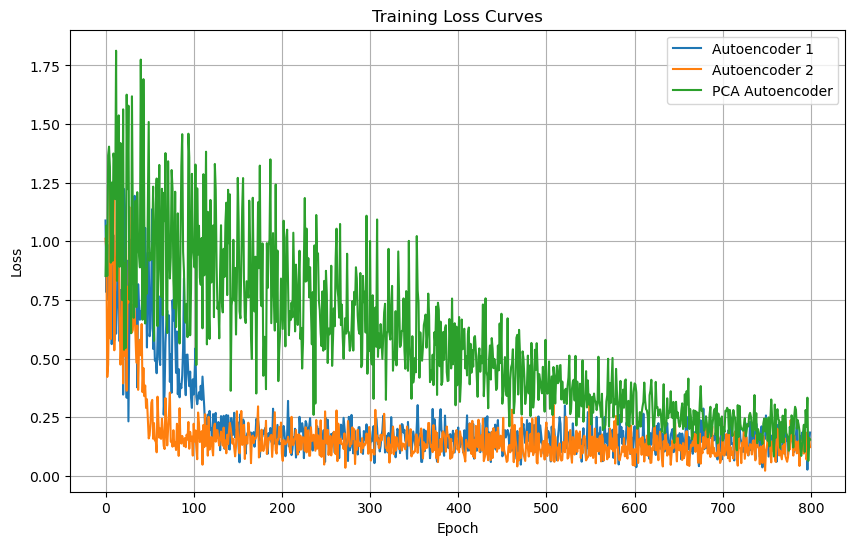

In [21]:
model_names = ["Autoencoder 1", "Autoencoder 2", "PCA Autoencoder"]
loss_curves = {}
for i, model in enumerate(models):
    #trainer.fit(model, data_loader)
    loss_curves[model_names[i]] = model.loss_curve

# Plot the loss curves
plt.figure(figsize=(10, 6))
for label, loss_curve in loss_curves.items():
    plt.plot(loss_curve[:800], label=label)
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [176]:
# Assuming you have `data_loader` and trained models
latent_embeddings = {}

for i, model in enumerate(models):
    input_data = []
    model.eval()  # Ensure the model is in evaluation mode
    embeddings = []
    with torch.no_grad():
        for batch in data_loader:
            x , y = batch
            input_data.append(x.numpy()) # Save original input data
            embeddings.append(model.encode(x).numpy())  # Obtain latent embeddings
    input_data = np.vstack(input_data)
    latent_embeddings[f"Model {i + 1}"] = np.vstack(embeddings)


In [120]:
latent_embeddings['Model 1'].shape

(96, 1)

In [22]:
embeddings1 = model_1.autoencoder.encoder(data)
embeddings2 = model_2.autoencoder.encoder(data)
embeddings3 = model_3.autoencoder.encoder(data)
embeddings = [embeddings1, embeddings2, embeddings3]

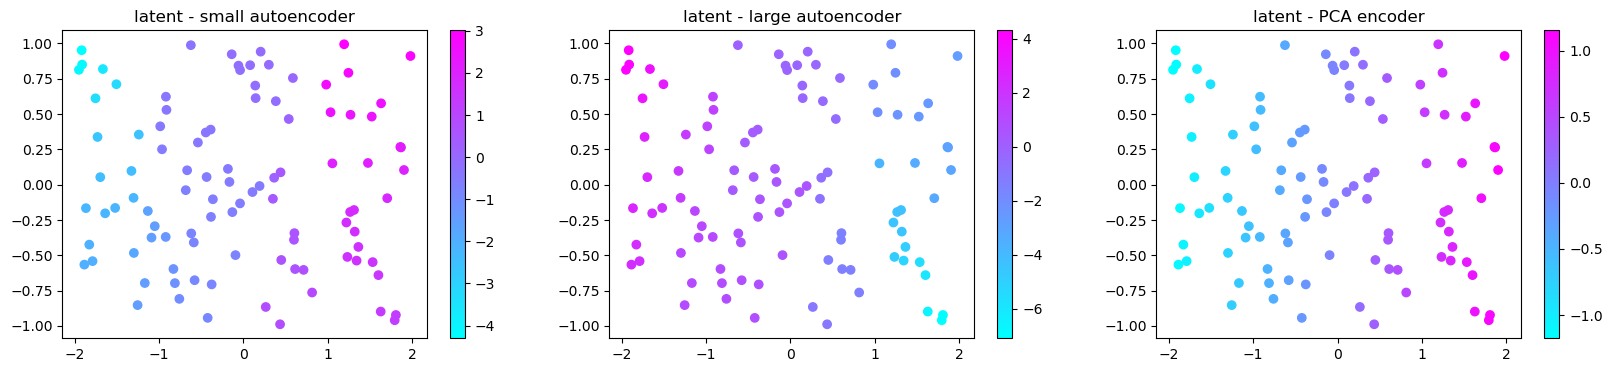

In [23]:
plt.rcParams["figure.figsize"] = (20,4)
plt.subplot(131)
plt.scatter(data[:, 0], data[:, 1], c=embeddings1[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - small autoencoder')

plt.subplot(132)
plt.scatter(data[:, 0], data[:, 1], c=embeddings2[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - large autoencoder')

plt.subplot(133)
plt.scatter(data[:, 0], data[:, 1], c=embeddings3[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - PCA encoder')
plt.show()

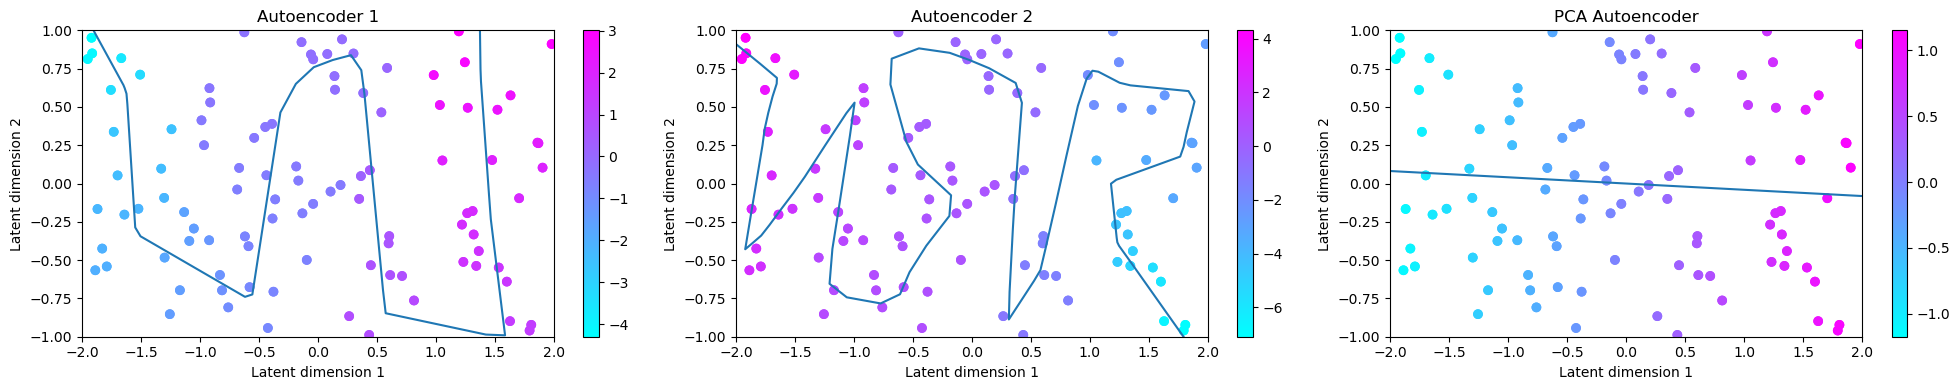

In [31]:
x = torch.tensor(np.linspace(-20, 20, 500)).float().reshape(-1,1)

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, embedding in enumerate(embeddings):
    ambient = models[i].autoencoder.decoder(x)
    ax[i].plot(ambient[:,0].detach().numpy(), ambient[:,1].detach().numpy())
    ax[i].scatter(data[:,0], data[:,1], c=embedding[:,0].detach().numpy(), cmap='cool')
    ax[i].set_title(model_names[i])
    ax[i].set_xlabel("Latent dimension 1")
    ax[i].set_ylabel("Latent dimension 2")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-1, 1)
    fig.colorbar(ax[i].scatter(data[:,0], data[:,1], c=embedding[:,0].detach().numpy(), cmap='cool'), ax=ax[i])
plt.tight_layout()
plt.show()


#### (c)

i) Random initialisation:
- Model 1:
    - Maps randomly to space - weights untrained
- Model 2:
    - More weights - more complex  still random
- Model 3:
    - Random patters

ii) Post-training
- Model 1:
    - Continuous smooth curves
- Model 2:
    - Continous smooth curves - better chance at catching nuance in the data
- Model 3:
    - Simple curves - mostly straight trajectories

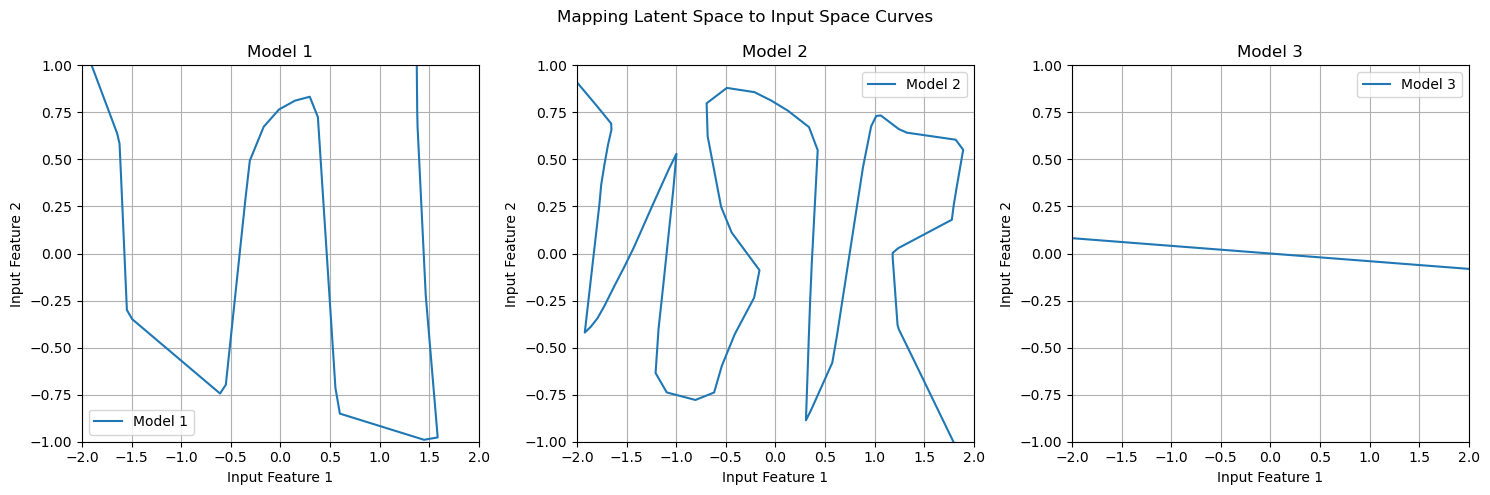

In [33]:
# Sample points in the latent space
latent_samples = np.linspace(-50, 30, 1000).reshape(-1, 1)  # 1D latent space

# Pass samples through the decoder for each model
input_curves = {}
for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        decoded_points = model.autoencoder.decoder(torch.tensor(latent_samples, dtype=torch.float32))
        input_curves[f"Model {i + 1}"] = decoded_points.numpy()

# Plot the curves
plt.figure(figsize=(15, 5))
for i, (model_name, curve) in enumerate(input_curves.items()):
    plt.subplot(1, len(models), i + 1)
    plt.plot(curve[:, 0], curve[:, 1], label=f"{model_name}")
    plt.title(f"{model_name}")
    plt.xlabel("Input Feature 1")
    plt.ylabel("Input Feature 2")
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(True)

plt.suptitle("Mapping Latent Space to Input Space Curves")
plt.tight_layout()
plt.show()


We see as predicted, model 1 pics up the general trend well, but model 2 is able to fit more precisely the nuance of the pattern.
The PCA picks up no nuance and gives a straight line.

#### (e)

n point in p dimensional space.
For p > 1, we are always losing information by reducing the dimensionality down to 1, the larger p is the worse this gets, and the less able to reconstuct the data it would be.

There are possible setups where it could be possible, if for example a 2d dataset lies on a 1d subset of the space. Again as p increases, this becomes increasingly unlikely 

#### (f)

Now decoder fixed $\rightarrow$ decoder weights cannot change
Now encoder learns to map to the latent space preset by the decoder, rather than the whole system.

This means the encoder will probably learn an optimal mapping to the latent space for the given decoder, but this is not necessarily the optimal mapping to the output space.


In [36]:
# Freezing the decoder parameters for each model
for param in model_1.autoencoder.decoder.parameters():
    param.requires_grad = False
for param in model_2.autoencoder.decoder.parameters():
    param.requires_grad = False
for param in model_3.autoencoder.decoder.parameters():
    param.requires_grad = False

# Retrain only the encoder for each model
encoder_trainers = [pl.Trainer(max_epochs=1000, enable_checkpointing=False) for _ in models]
for i, model in enumerate(models):
    encoder_trainers[i].fit(model, data_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode
---------------------------------------------------
0 | autoencoder | Autoencoder | 563    | eval
---------------------------------------------------
281       Trainable params
282       Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
0         Modules in train mode
13        Modules in eval mode
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in th

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.

  | Name        | Type        | Params | Mode
---------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | eval
---------------------------------------------------
5.3 K     Trainable params
5.3 K     Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
0         Modules in train mode
17        Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.

  | Name        | Type           | Params | Mode
------------------------------------------------------
0 | autoencoder | PCAAutoencoder | 4      | eval
------------------------------------------------------
2         Trainable params
2         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
3         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


C:\Users\samhe\AppData\Local\Temp\ipykernel_19028\1900789411.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.78, 1])  # Adjust for colorbar space


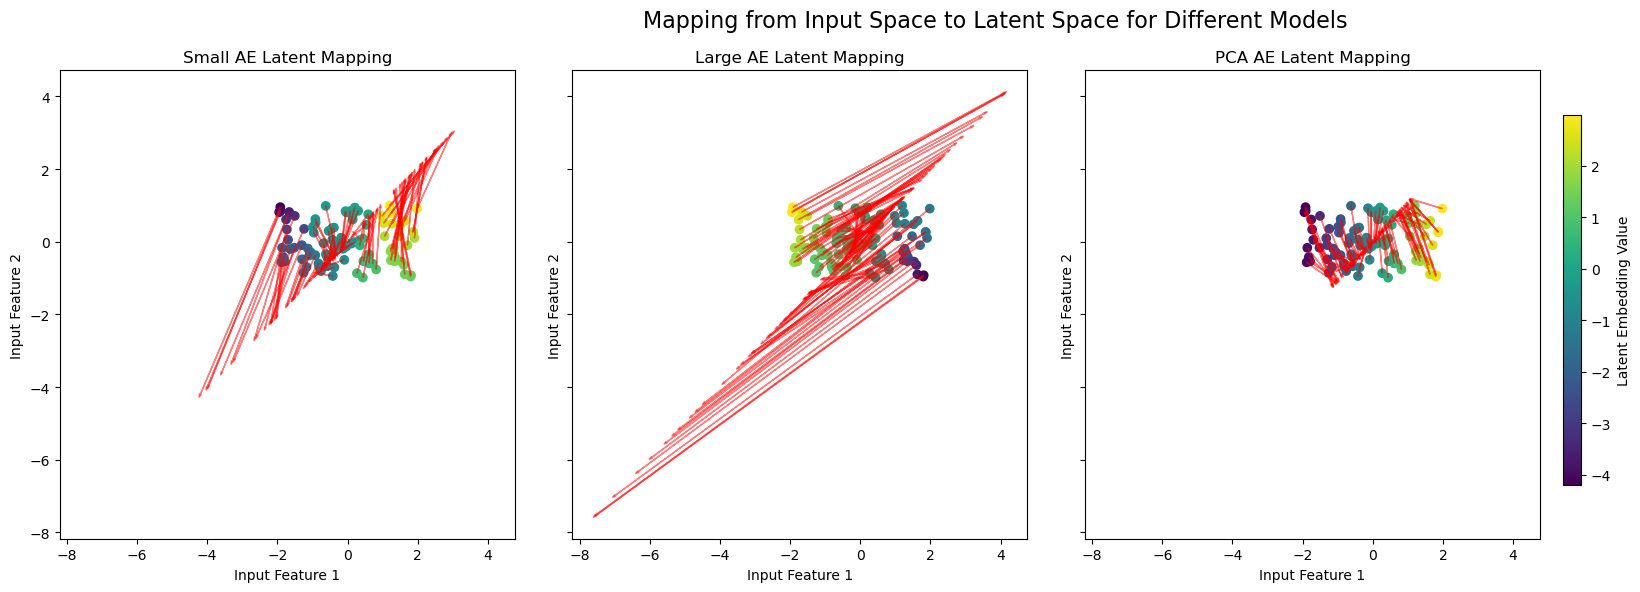

In [42]:
def visualize_arrows(model, data_loader, model_name, ax):
    """
    Visualize the mapping from input space to latent space using arrows for a given model.
    """
    # Collect input data and latent embeddings after encoder retraining
    input_data = []
    latent_embeddings = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in data_loader:
            x, _ = batch  # data, labels
            input_data.append(x.numpy())  # Save original input data
            latent_embeddings.append(model.encode(x).numpy())  # Get latent embeddings

    input_data = np.vstack(input_data)
    latent_embeddings = np.vstack(latent_embeddings)

    # Scatter plot the input data in 2D (using the latent values as color)
    scatter = ax.scatter(input_data[:, 0], input_data[:, 1], c=latent_embeddings[:, 0], cmap="viridis")
    
    # Add arrows showing how points map from input space to latent space (1D)
    for i in range(len(input_data)):
        ax.arrow(input_data[i, 0], input_data[i, 1],
                 latent_embeddings[i, 0] - input_data[i, 0],  # No change in x-direction (latent space is 1D)
                 latent_embeddings[i, 0] - input_data[i, 1],  # Change in y-direction (latent space is 1D)
                 color="red", alpha=0.5, head_width=0.05, head_length=0.1)
    
    ax.set_xlabel("Input Feature 1")
    ax.set_ylabel("Input Feature 2")
    ax.set_title(f"{model_name} Latent Mapping")
    return scatter

# Create subplots to visualize all three models side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Visualize each model
scatter_1 = visualize_arrows(model_1, data_loader, "Small AE", axes[0])
scatter_2 = visualize_arrows(model_2, data_loader, "Large AE", axes[1])
scatter_3 = visualize_arrows(model_3, data_loader, "PCA AE", axes[2])

# Add a shared colorbar
fig.colorbar(scatter_1, ax=axes, location='right', shrink=0.8, label="Latent Embedding Value")

# Set a super title for the entire figure
plt.suptitle("Mapping from Input Space to Latent Space for Different Models", fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.78, 1])  # Adjust for colorbar space
plt.show()


In [44]:
import re
latent_trained = model_1.autoencoder.encoder(data)

params_encoder_trained = []
params_decoder_trained = []
for name, param in model_1.autoencoder.named_parameters():
    if re.match(r'^decoder\.', name) != None:
        param.requires_grad = False
        params_decoder_trained.append(param)
    else:
        params_encoder_trained.append(param.detach().numpy().flatten())

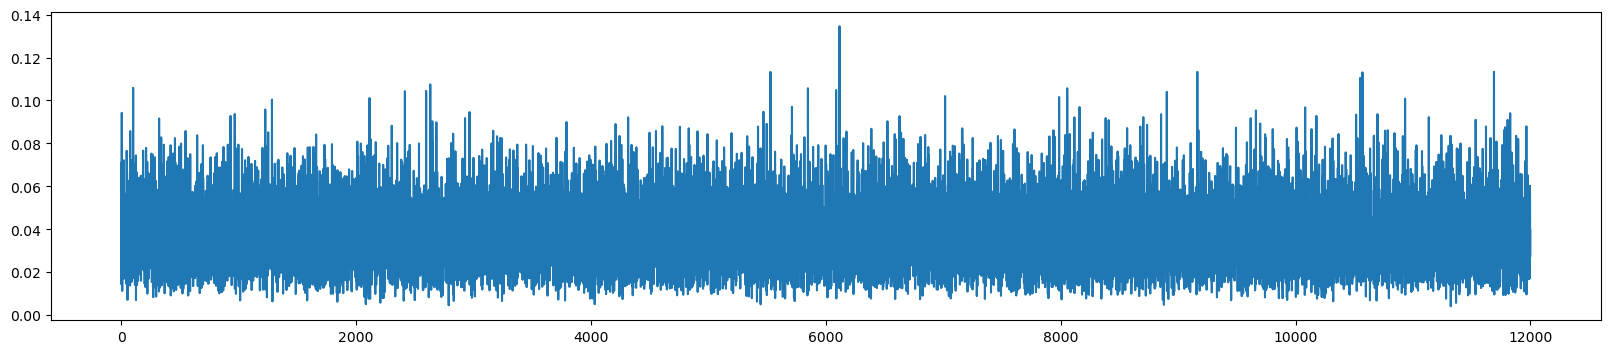

In [45]:
params_encoder_retrained = []
for name, param in model_1.autoencoder.named_parameters():
    if param.requires_grad == True:
        params_encoder_retrained.append(param.detach().numpy().flatten())

plt.plot(model_1.loss_curve)

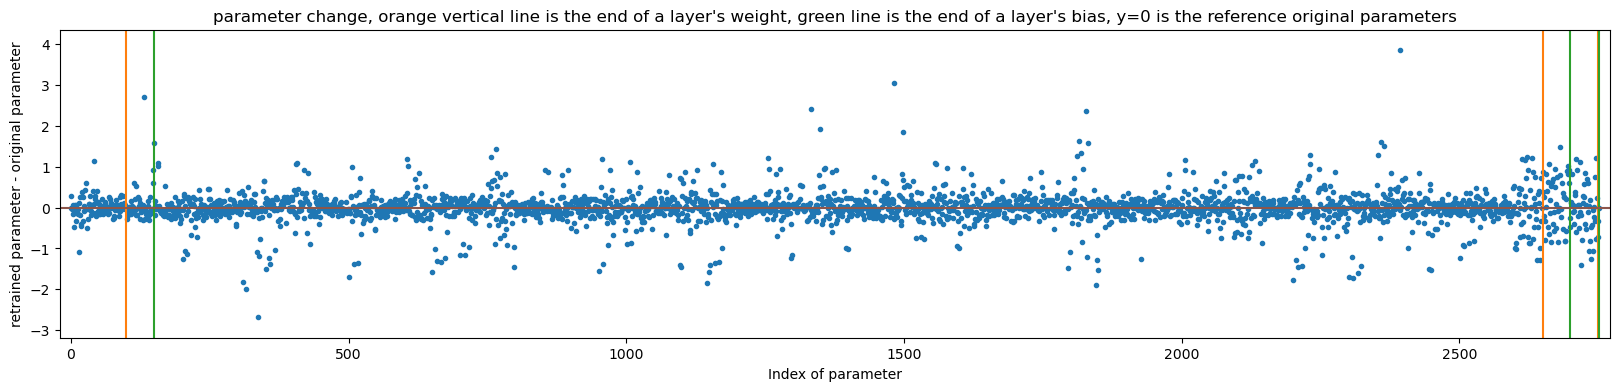

In [ ]:
z0 = np.zeros((2, 1))
for x, y in zip(params_encoder_trained, params_encoder_retrained):
    z = np.stack((x, y))
    z0 = np.concatenate((z, z0), axis=-1)


plt.rcParams["figure.figsize"] = (20,4)
plt.scatter(range(len(z0[0])), z0[1] - z0[0], marker='.')
pos = 0
for name, param in model_1.autoencoder.named_parameters():
    if param.requires_grad == True:
        pos += param.detach().numpy().flatten().shape[0]
        plt.vlines(pos, min(z0[1] - z0[0])-1, max(z0[1] - z0[0])+1, colors='C1' if re.search(r'bias$', name) == None else 'C2')
        
plt.hlines(0, -20, pos+20, colors='C5')
plt.title('parameter change, orange vertical line is the end of a layer\'s weight, green line is the end of a layer\'s bias, y=0 is the reference original parameters')
plt.xlim(-20, pos+20)
plt.ylim(min(z0[1] - z0[0])-0.5, max(z0[1] - z0[0])+0.5)
plt.xlabel('Index of parameter')
plt.ylabel('retrained parameter - original parameter')
plt.show()

First compare SGD to Adam

In [57]:
class AutoencoderModule(pl.LightningModule):
    def __init__(self, model, optimizer_type='sgd', **model_kwargs):
        super().__init__()
        self.autoencoder = model(**model_kwargs)
        self.loss_curve_with_examples = []  # List to track loss with number of examples processed
        self.num_examples_processed = 0  # Track number of examples processed
        self.optimizer_type = optimizer_type

    def forward(self, x):
        return self.autoencoder(x)

    def encode(self, x):
        """Returns the latent embeddings of the input."""
        return self.autoencoder.encoder(x)

    def configure_optimizers(self):
        if self.optimizer_type == 'gd':
            # Use Gradient Descent (full batch)
            optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
            return optimizer
        elif self.optimizer_type == 'sgd':
            # Use Stochastic Gradient Descent (mini-batch)
            optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
            return optimizer

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve_with_examples.append((self.num_examples_processed, loss.item()))
        
        # Track number of training examples seen so far (after each batch)
        self.num_examples_processed += len(x)
        
        return loss

    def on_train_start(self):
        self.loss_curve_with_examples = []
        self.num_examples_processed = 0


In [58]:
# Define the models with both optimizers
model_gd = AutoencoderModule(model=Autoencoder, hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1, optimizer_type='gd')
model_sgd = AutoencoderModule(model=Autoencoder, hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1, optimizer_type='sgd')

# Create a PyTorch Lightning trainer for both optimizers
trainer_gd = pl.Trainer(max_epochs=100, enable_checkpointing=False)
trainer_sgd = pl.Trainer(max_epochs=100, enable_checkpointing=False)

# Train the models
trainer_gd.fit(model_gd, data_loader)
trainer_sgd.fit(model_sgd, data_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


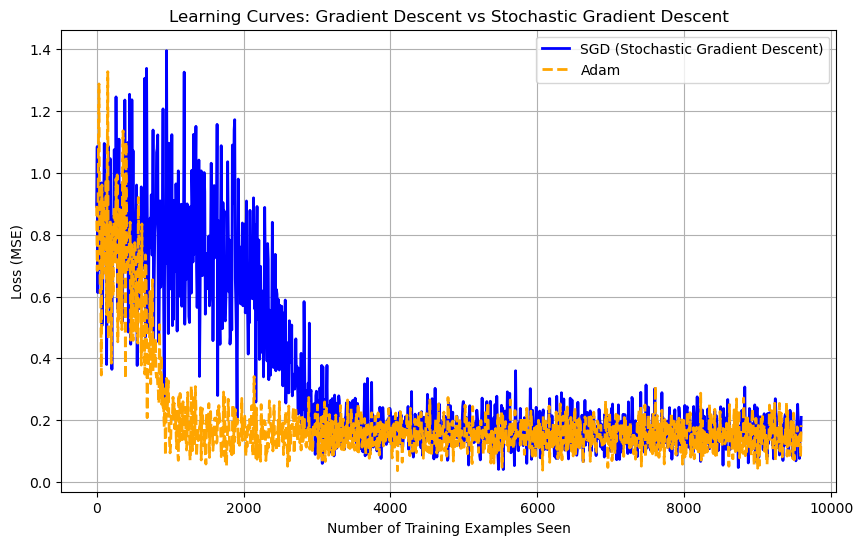

In [59]:
# Extract learning curves for both optimizers
loss_curve_gd = np.array([x[1] for x in model_gd.loss_curve_with_examples])
loss_curve_sgd = np.array([x[1] for x in model_sgd.loss_curve_with_examples])

examples_gd = np.array([x[0] for x in model_gd.loss_curve_with_examples])
examples_sgd = np.array([x[0] for x in model_sgd.loss_curve_with_examples])

# Plot the learning curves
plt.figure(figsize=(10, 6))

plt.plot(examples_gd, loss_curve_gd, label="SGD (Stochastic Gradient Descent)", color='blue', linestyle='-', linewidth=2)
plt.plot(examples_sgd, loss_curve_sgd, label="Adam", color='orange', linestyle='--', linewidth=2)

plt.title("Learning Curves: Gradient Descent vs Stochastic Gradient Descent")
plt.xlabel("Number of Training Examples Seen")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


SGD vs GD, to create GD we set batch size = num_samples

In [47]:
class AutoencoderModule_SGD(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # SGD / GD optimizer
        optimizer = torch.optim.SGD(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [48]:
mini_batch_size = 8
data_loader_SGD = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True, drop_last=True)
data_loader_GD = DataLoader(dataset, batch_size=num_samples, shuffle=True, drop_last=True)

In [53]:
trainer = pl.Trainer(max_epochs=1000)
autoencoder_moduleSGD = AutoencoderModule_SGD(hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1)

trainer.fit(autoencoder_moduleSGD, data_loader_SGD)

trainer = pl.Trainer(max_epochs=1000)
autoencoder_moduleGD = AutoencoderModule_SGD(hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1)

trainer.fit(autoencoder_moduleGD, data_loader_GD)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(lo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
c:\Users\samhe\miniconda3\envs\mlph3\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


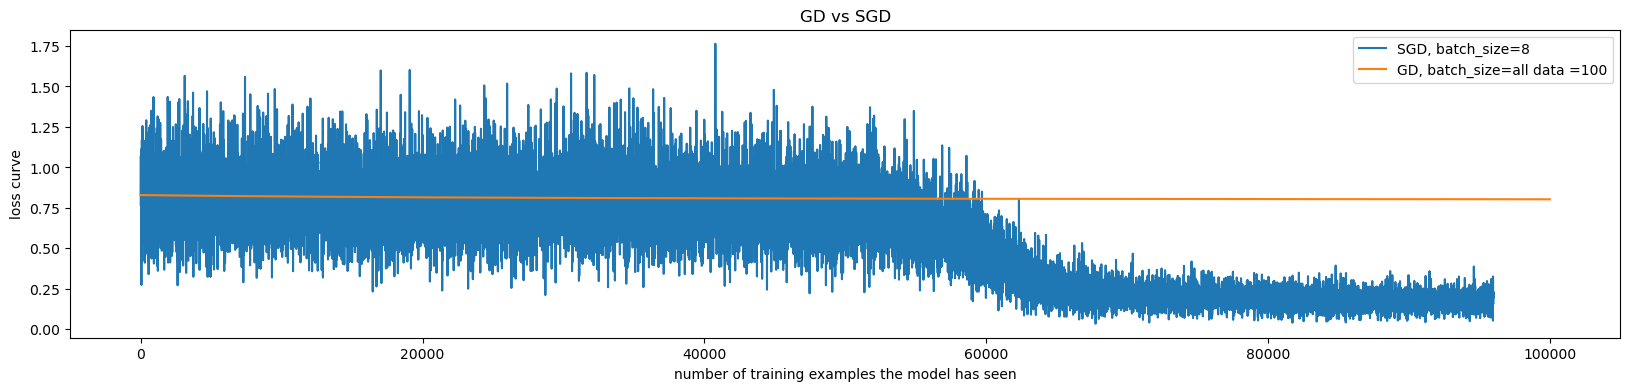

In [54]:
xGD = np.linspace(0, len(autoencoder_moduleGD.loss_curve)*num_samples, len(autoencoder_moduleGD.loss_curve))
xSGD = np.linspace(0, len(autoencoder_moduleSGD.loss_curve)*mini_batch_size, len(autoencoder_moduleSGD.loss_curve))
plt.plot(xSGD, autoencoder_moduleSGD.loss_curve, label='SGD, batch_size='+str(mini_batch_size))
plt.plot(xGD, autoencoder_moduleGD.loss_curve, label='GD, batch_size=all data =' + str(num_samples))
plt.legend()
plt.xlabel('number of training examples the model has seen')
plt.ylabel('loss curve')
plt.title('GD vs SGD')
plt.show()

Clearly SGD is bettter

### Question 2
### a)

![image info](./Q2_screenshot/a.png)

### b)

### Without Regularization:
![image info](./Q2_screenshot/b_noRegular.png)

### L1 Regularization:
![image info](./Q2_screenshot/b_L1.png)

### L2 Regularization:
![image info](./Q2_screenshot/b_L2.png)

L1 regularization suppressed most of the parameters close to zero. In each layer, there are a few parameters with high values.

L2 regularization suppressed all parameters to small values.

This makes sense because L1 regularization tends to have sparse solution.

### c)
![image info](./Q2_screenshot/c.png)

We observe that when the training dataset is not large enough to include most of the features of all dataset, large scale networks tend to overfit and capture non general pattern in training dataset.